# Options

In [7]:
#!pip install pandas-datareader
#!pip install matplotlib

In [8]:
# various pandas, numpy
import pandas as pd
import numpy as np
#import pandas.io.data as web
import pandas_datareader as web

from datetime import datetime
from datetime import date

# plotting
import matplotlib.pyplot as plt

# make plots inline
%matplotlib inline

# formatting options
pd.set_option('display.notebook_repr_html', False)

pd.set_option('display.max_columns', 7)
pd.set_option('display.max_rows', 10) 
pd.set_option('display.width', 82) 
pd.set_option('precision', 3)

# Options data from Yahoo!

In [2]:
# retrieve options from Yahoo for AAPL
#aapl_options = web.Options('AAPL', 'yahoo')

# data is not actually retrieved until explicitly requesting.
#aapl_options = aapl_options.get_all_data().reset_index()

In [3]:
# save to a snapshot for easy reuse / offline processing
#aapl_options.to_csv('aapl_options.csv')

In [9]:
# or, load snapshot
aapl_options = pd.read_csv('aapl_options.csv', 
                           parse_dates=['Expiry'])

In [10]:
# let's restructure and tidy this data to be useful in the examples
aos = aapl_options.sort(['Expiry', 'Strike'])[
    ['Expiry', 'Strike', 'Type', 'IV', 'Bid', 
     'Ask', 'Underlying_Price']] 
aos['IV'] = aos['IV'].apply(lambda x: float(x.strip('%')))

/Users/kcom/minic/envs/3.5/lib/python3.5/site-packages/ipykernel_launcher.py:2: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
  


In [11]:
# take a peek at the options data
aos[:5]

        Expiry  Strike  Type      IV    Bid    Ask  Underlying_Price
158 2015-02-27    75.0  call  271.88  53.60  53.85            128.79
159 2015-02-27    75.0   put  193.75   0.00   0.01            128.79
190 2015-02-27    80.0  call  225.78  48.65  48.80            128.79
191 2015-02-27    80.0   put  171.88   0.00   0.01            128.79
226 2015-02-27    85.0  call  199.22  43.65  43.80            128.79

In [13]:
# we have the following distinct dates for options available on AAPL
aos['Expiry'].unique()

array(['2015-02-27T00:00:00.000000000', '2015-03-06T00:00:00.000000000',
       '2015-03-13T00:00:00.000000000', '2015-03-20T00:00:00.000000000',
       '2015-03-27T00:00:00.000000000', '2015-04-02T00:00:00.000000000',
       '2015-04-17T00:00:00.000000000', '2015-05-15T00:00:00.000000000',
       '2015-07-17T00:00:00.000000000', '2015-10-16T00:00:00.000000000',
       '2016-01-15T00:00:00.000000000', '2017-01-20T00:00:00.000000000'], dtype='datetime64[ns]')

In [14]:
# call option
aos.loc[158]

Expiry              2015-02-27 00:00:00
Strike                               75
Type                               call
IV                                  272
Bid                                53.6
Ask                                53.9
Underlying_Price                    129
Name: 158, dtype: object

## Implied volatility

In [15]:
# all calls on expiry date of 2015-02-27
calls1 = aos[(aos.Expiry=='2015-02-27') & (aos.Type=='call')]
calls1[:5]

        Expiry  Strike  Type      IV    Bid    Ask  Underlying_Price
158 2015-02-27    75.0  call  271.88  53.60  53.85            128.79
190 2015-02-27    80.0  call  225.78  48.65  48.80            128.79
226 2015-02-27    85.0  call  199.22  43.65  43.80            128.79
265 2015-02-27    90.0  call  175.00  38.65  38.80            128.79
303 2015-02-27    93.0  call  160.16  35.65  35.80            128.79

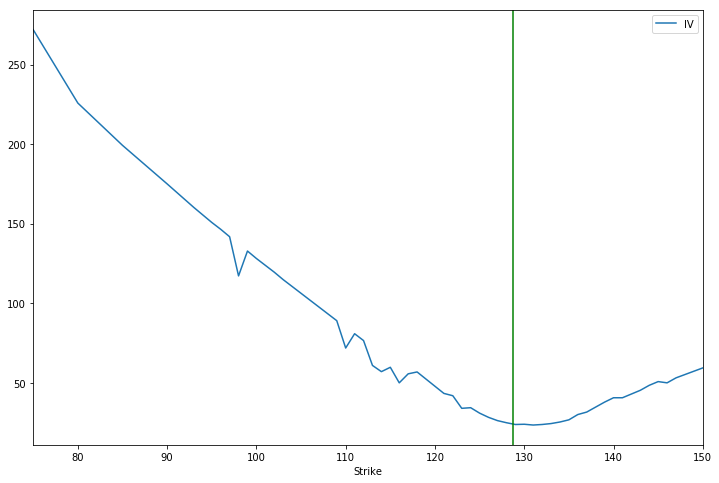

In [16]:
# IV tends to be minimized at the underlying price
ax = aos[(aos.Expiry=='2015-02-27') & (aos.Type=='call')] \
        .set_index('Strike')[['IV']].plot(figsize=(12,8))
ax.axvline(calls1.Underlying_Price.iloc[0], color='g');
#plt.savefig('5104OS_08_01.png', bbox_inches='tight', dpi=300)

# Calculating payoff on options

## Call option payoff calculation

In [17]:
def call_payoff(price_at_maturity, strike_price):
    return max(0, price_at_maturity - strike_price)

In [18]:
# out-of-the-money
call_payoff(25, 30)

0

In [19]:
# in-the-money
call_payoff(35, 30)

5

In [20]:
def call_payoffs(min_maturity_price, max_maturity_price, 
                 strike_price, step=1):
    """
    Calculate the payoffs for a range of maturity prices at 
    a given strike price
    """
    maturities = np.arange(min_maturity_price, 
                           max_maturity_price + step, step)
    payoffs = np.vectorize(call_payoff)(maturities, strike_price)
    df = pd.DataFrame({'Strike': strike_price, 'Payoff': payoffs}, 
                      index=maturities)
    df.index.name = 'Maturity Price'
    return df

In [21]:
# calculate call payoffs for...
call_payoffs(10, 25, 15)

                Payoff  Strike
Maturity Price                
10                   0      15
11                   0      15
12                   0      15
13                   0      15
14                   0      15
...                ...     ...
21                   6      15
22                   7      15
23                   8      15
24                   9      15
25                  10      15

[16 rows x 2 columns]

In [22]:
def plot_call_payoffs(min_maturity_price, max_maturity_price, 
                      strike_price, step=1):
    """
    Plot a canonical call option payoff graph
    """
    payoffs = call_payoffs(min_maturity_price, max_maturity_price, 
                           strike_price, step)
    plt.figure(figsize=(12,8))
    plt.ylim(payoffs.Payoff.min() - 10, payoffs.Payoff.max() + 10)
    plt.ylabel("Payoff")
    plt.xlabel("Maturity Price")
    plt.title('Payoff of call option, Strike={0}'
              .format(strike_price))
    plt.xlim(min_maturity_price, max_maturity_price)
    plt.plot(payoffs.index, payoffs.Payoff.values);

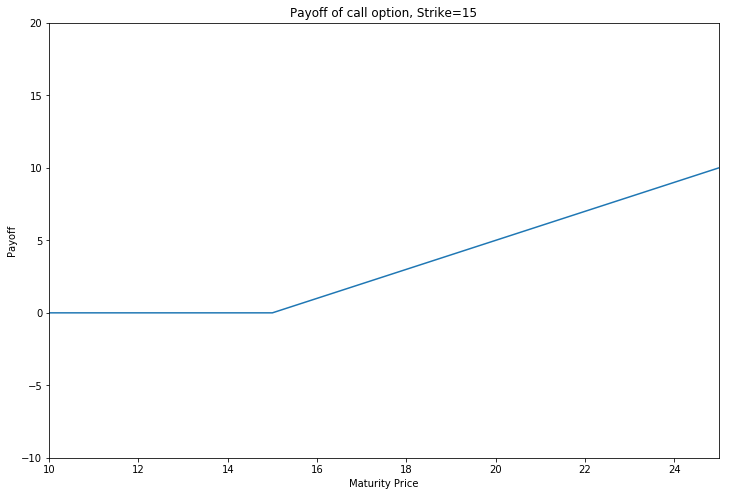

In [23]:
plot_call_payoffs(10, 25, 15)
#plt.savefig('5104OS_08_07.png', bbox_inches='tight', dpi=300)

## Put option payoff calculation

In [24]:
def put_payoff(price_at_maturity, strike_price):
    """
    return the put payoff
    """
    return max(0, strike_price - price_at_maturity)

In [25]:
# out-of-the-money
put_payoff(25, 20)

0

In [26]:
# in-the-money
put_payoff(15, 20)

5

In [27]:
def put_payoffs(min_maturity_price, max_maturity_price, 
                strike_price, step=1):
    """
    Calculate the payoffs for a range of maturity prices 
    at a given strike price
    """
    maturities = np.arange(min_maturity_price, 
                           max_maturity_price + step, step)
    payoffs = np.vectorize(put_payoff)(maturities, strike_price)
    df = pd.DataFrame({'Payoff': payoffs, 'Strike': strike_price},
                      index=maturities)
    df.index.name = 'Maturity Price'
    return df

In [28]:
# calculate call payoffs for 
put_payoffs(10, 25, 15)

                Payoff  Strike
Maturity Price                
10                   5      15
11                   4      15
12                   3      15
13                   2      15
14                   1      15
...                ...     ...
21                   0      15
22                   0      15
23                   0      15
24                   0      15
25                   0      15

[16 rows x 2 columns]

In [29]:
def plot_put_payoffs(min_maturity_price, 
                     max_maturity_price, 
                     strike_price, 
                     step=1):
    """
    Plot a canonical call option payoff graph
    """
    payoffs = put_payoffs(min_maturity_price, 
                          max_maturity_price, 
                          strike_price, step)
    plt.figure(figsize=(12,8))
    plt.ylim(payoffs.Payoff.min() - 10, payoffs.Payoff.max() + 10)
    plt.ylabel("Payoff")
    plt.xlabel("Maturity Price")
    plt.title('Payoff of put option, Strike={0}'
              .format(strike_price))
    plt.xlim(min_maturity_price, max_maturity_price)
    plt.plot(payoffs.index, payoffs.Payoff.values);

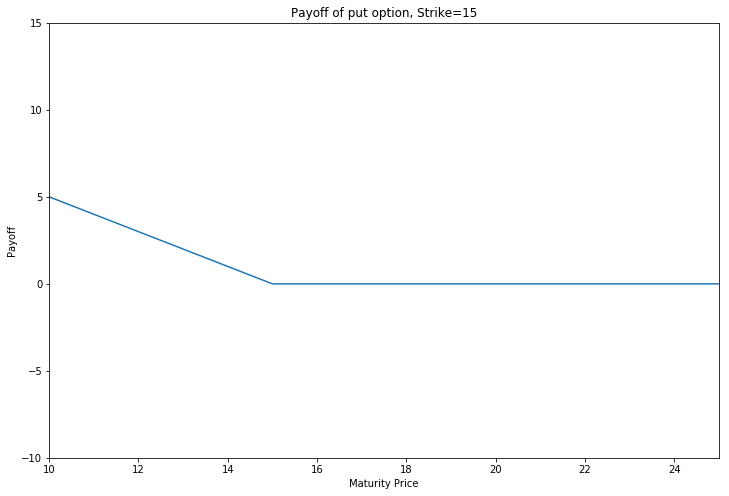

In [30]:
plot_put_payoffs(10, 25, 15)
#plt.savefig('5104OS_08_08.png', bbox_inches='tight', dpi=300)

# Profit and loss calculation

## Call option PnL for the Buyer

In [31]:
def call_pnl_buyer(premium, strike_price, min_maturity_price, 
                   max_maturity_price, step = 1):
    payoffs = call_payoffs(min_maturity_price, max_maturity_price, 
                           strike_price)
    payoffs['Premium'] = premium
    payoffs['PnL'] = payoffs.Payoff - premium
    return payoffs

In [32]:
pnl_buyer = call_pnl_buyer(12, 15, 10, 35)
pnl_buyer

                Payoff  Strike  Premium  PnL
Maturity Price                              
10                   0      15       12  -12
11                   0      15       12  -12
12                   0      15       12  -12
13                   0      15       12  -12
14                   0      15       12  -12
...                ...     ...      ...  ...
31                  16      15       12    4
32                  17      15       12    5
33                  18      15       12    6
34                  19      15       12    7
35                  20      15       12    8

[26 rows x 4 columns]

In [33]:
def plot_pnl(pnl_df, okind, who):
    plt.figure(figsize=(12,8))
    plt.ylim(pnl_df.Payoff.min() - 10, pnl_df.Payoff.max() + 10)
    plt.ylabel("Profit / Loss")
    plt.xlabel("Maturity Price")
    plt.title('Profit and loss of {0} option, {1}, Premium={2} Strike={3}'
              .format(okind, who, pnl_df.Premium.iloc[0], 
                      pnl_df.Strike.iloc[0]))
    plt.ylim(pnl_df.PnL.min()-3, pnl_df.PnL.max() + 3)
    plt.xlim(pnl_df.index[0], pnl_df.index[len(pnl_df.index)-1])
    plt.plot(pnl_df.index, pnl_df.PnL)
    plt.axhline(0, color='g');

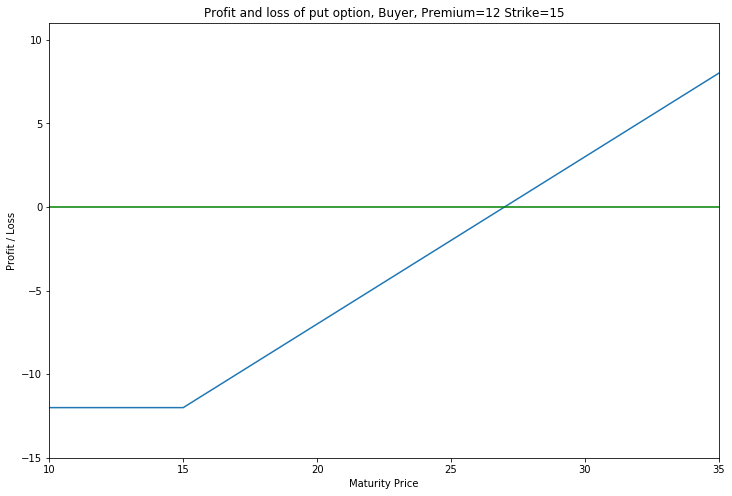

In [34]:
plot_pnl(pnl_buyer, "put", "Buyer")
#plt.savefig('5104OS_08_09.png', bbox_inches='tight', dpi=300)

## Call option Profit and Loss for the seller

In [35]:
def call_pnl_seller(premium, strike_price, min_maturity_price, 
                    max_maturity_price, step = 1):
    payoffs = call_payoffs(min_maturity_price, max_maturity_price, 
                           strike_price)
    payoffs['Premium'] = premium
    payoffs['PnL'] = premium - payoffs.Payoff
    return payoffs

In [36]:
pnl_seller = call_pnl_seller(12, 15, 10, 35)
pnl_seller

                Payoff  Strike  Premium  PnL
Maturity Price                              
10                   0      15       12   12
11                   0      15       12   12
12                   0      15       12   12
13                   0      15       12   12
14                   0      15       12   12
...                ...     ...      ...  ...
31                  16      15       12   -4
32                  17      15       12   -5
33                  18      15       12   -6
34                  19      15       12   -7
35                  20      15       12   -8

[26 rows x 4 columns]

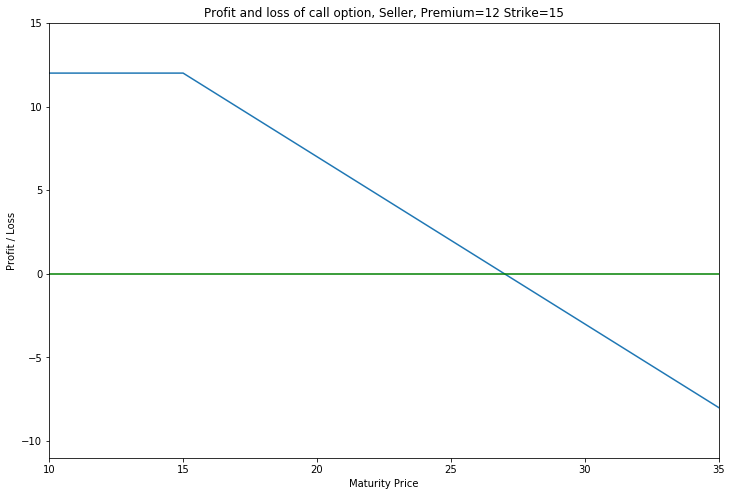

In [37]:
plot_pnl(pnl_seller, "call", "Seller")
#plt.savefig('5104OS_08_10.png', bbox_inches='tight', dpi=300)

In [38]:
def plot_combined_pnl(pnl_df):
    plt.figure(figsize=(12,8))
    plt.ylim(pnl_df.Payoff.min() - 10, pnl_df.Payoff.max() + 10)
    plt.ylabel("Profit / Loss")
    plt.xlabel("Maturity Price")
    plt.title('Profit and loss of call option Strike={0}'
              .format(pnl_df.Strike.iloc[0]))
    plt.ylim(min(pnl_df.PnLBuyer.min(), pnl_df.PnLSeller.min()) - 3, 
             max(pnl_df.PnLBuyer.max(), pnl_df.PnLSeller.max()) + 3)
    plt.xlim(pnl_df.index[0], pnl_df.index[len(pnl_df.index)-1])
    plt.plot(pnl_df.index, pnl_df.PnLBuyer, color='b')
    plt.plot(pnl_df.index, pnl_df.PnLSeller, color='r')
    plt.axhline(0, color='g');

In [39]:
pnl_combined = pd.DataFrame({'PnLBuyer': pnl_buyer.PnL,
                             'PnLSeller': pnl_seller.PnL,
                             'Premium': pnl_buyer.Premium,
                             'Strike': pnl_buyer.Strike,
                             'Payoff': pnl_buyer.Payoff})
pnl_combined

                Payoff  PnLBuyer  PnLSeller  Premium  Strike
Maturity Price                                              
10                   0       -12         12       12      15
11                   0       -12         12       12      15
12                   0       -12         12       12      15
13                   0       -12         12       12      15
14                   0       -12         12       12      15
...                ...       ...        ...      ...     ...
31                  16         4         -4       12      15
32                  17         5         -5       12      15
33                  18         6         -6       12      15
34                  19         7         -7       12      15
35                  20         8         -8       12      15

[26 rows x 5 columns]

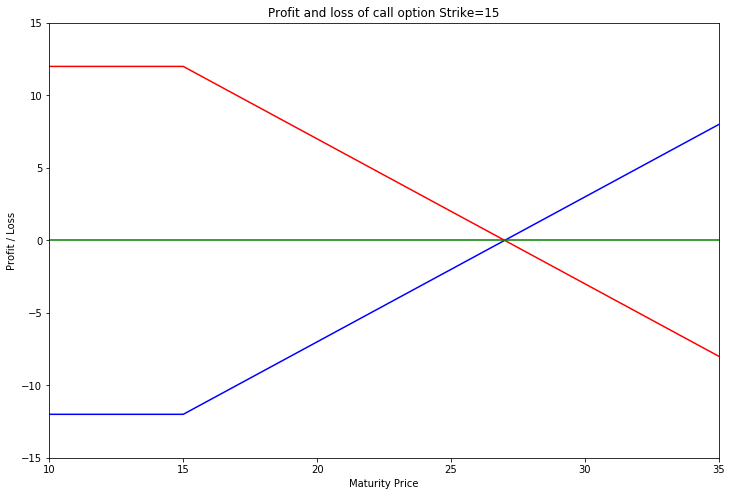

In [40]:
plot_combined_pnl(pnl_combined)
#plt.savefig('5104OS_08_11.png', bbox_inches='tight', dpi=300)

## Put option profit and loss for the Buyer

In [41]:
def put_pnl_buyer(premium, strike_price, min_maturity_price, 
                  max_maturity_price, step = 1):
    payoffs = put_payoffs(min_maturity_price, max_maturity_price, 
                          strike_price)
    payoffs['Premium'] = premium
    payoffs['Strike'] = strike_price
    payoffs['PnL'] = payoffs.Payoff - payoffs.Premium
    return payoffs

In [42]:
pnl_put_buyer = put_pnl_buyer(2, 15, 10, 30)
pnl_put_buyer

                Payoff  Strike  Premium  PnL
Maturity Price                              
10                   5      15        2    3
11                   4      15        2    2
12                   3      15        2    1
13                   2      15        2    0
14                   1      15        2   -1
...                ...     ...      ...  ...
26                   0      15        2   -2
27                   0      15        2   -2
28                   0      15        2   -2
29                   0      15        2   -2
30                   0      15        2   -2

[21 rows x 4 columns]

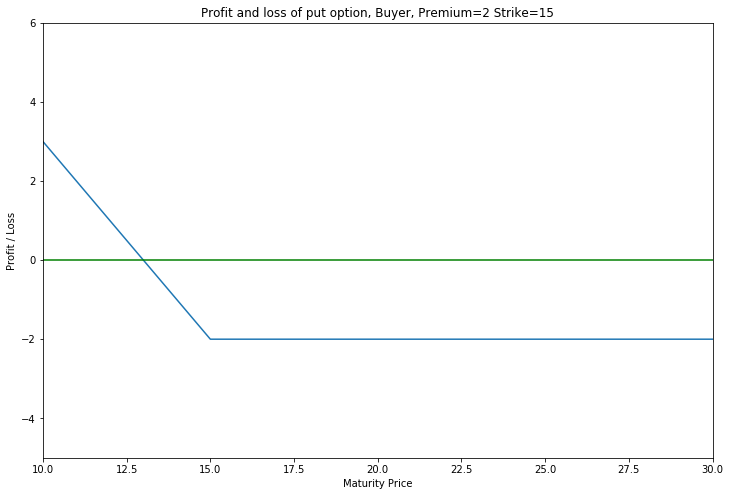

In [43]:
plot_pnl(pnl_put_buyer, "put", "Buyer")
#plt.savefig('5104OS_08_12.png', bbox_inches='tight', dpi=300)

## Put Option PnL for the Seller

In [44]:
def put_pnl_seller(premium, strike_price, min_maturity_price, 
                   max_maturity_price, step = 1):
    payoffs = put_payoffs(min_maturity_price, max_maturity_price, 
                          strike_price)
    payoffs['Premium'] = premium
    payoffs['Strike'] = strike_price
    payoffs['PnL'] = payoffs.Premium - payoffs.Payoff
    return payoffs

In [45]:
pnl_put_seller = put_pnl_seller(2, 15, 10, 30)
pnl_put_seller

                Payoff  Strike  Premium  PnL
Maturity Price                              
10                   5      15        2   -3
11                   4      15        2   -2
12                   3      15        2   -1
13                   2      15        2    0
14                   1      15        2    1
...                ...     ...      ...  ...
26                   0      15        2    2
27                   0      15        2    2
28                   0      15        2    2
29                   0      15        2    2
30                   0      15        2    2

[21 rows x 4 columns]

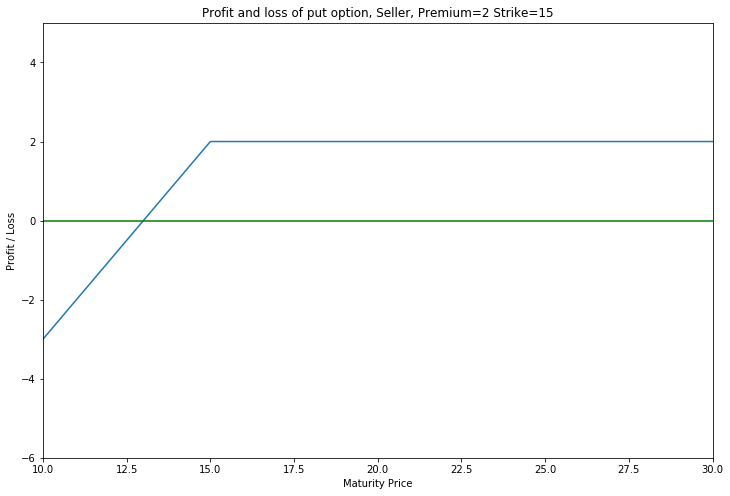

In [46]:
plot_pnl(pnl_put_seller, "put", "Seller")
#plt.savefig('5104OS_08_13.png', bbox_inches='tight', dpi=300)

# Black-Scholes using Mibian

In [47]:
aos[aos.Expiry=='2016-01-15'][:2]

      Expiry  Strike  Type     IV    Bid    Ask  Underlying_Price
0 2016-01-15   34.29  call  57.23  94.10  94.95            128.79
1 2016-01-15   34.29   put  52.73   0.01   0.07            128.79

In [48]:
date(2016, 1, 15) - date(2015, 2, 25)

datetime.timedelta(324)

In [54]:
#!pip install mibian
#!pip install scipy

In [56]:
import mibian
c = mibian.BS([128.79, 34.29, 1, 324], 57.23)

NameError: name 'norm' is not defined

In [44]:
c.callPrice

94.878970089456217

In [45]:
c.putPrice

0.075934592996542705

In [46]:
c = mibian.BS([128.79, 34.29, 1, 324], 
              callPrice=94.878970089456217 )
c.impliedVolatility

57.22999572753906

### Charting option price change over time

In [47]:
df = pd.DataFrame({'DaysToExpiry': np.arange(364, 0, -1)})
df

     DaysToExpiry
0             364
1             363
2             362
3             361
4             360
..            ...
359             5
360             4
361             3
362             2
363             1

[364 rows x 1 columns]

In [48]:
bs_v1 = mibian.BS([128.79, 34.29, 1, 324], volatility=57.23)
calc_call = lambda r: mibian.BS([128.79, 34.29, 1, 
                                 r.DaysToExpiry], 
                                volatility=57.23).callPrice
df['CallPrice'] = df.apply(calc_call, axis=1)
df

     DaysToExpiry  CallPrice
0             364      94.96
1             363      94.96
2             362      94.96
3             361      94.96
4             360      94.95
..            ...        ...
359             5      94.50
360             4      94.50
361             3      94.50
362             2      94.50
363             1      94.50

[364 rows x 2 columns]

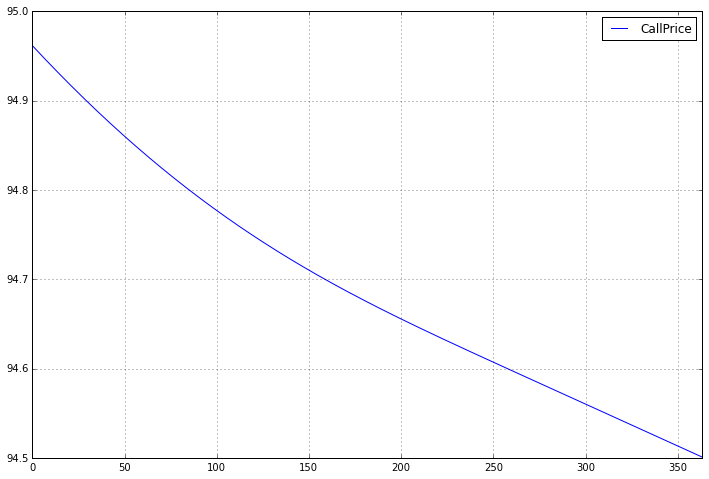

In [49]:
df[['CallPrice']].plot(figsize=(12,8));
#plt.savefig('5104OS_08_40.png', bbox_inches='tight', dpi=300)

## The Greeks

### Calculation and visualization

In [50]:
greeks = pd.DataFrame()
delta = lambda r: mibian.BS([r.Price, 60, 1, 180], 
                            volatility=30).callDelta
gamma = lambda r: mibian.BS([r.Price, 60, 1, 180], 
                            volatility=30).gamma
theta = lambda r: mibian.BS([r.Price, 60, 1, 180], 
                            volatility=30).callTheta
vega = lambda r: mibian.BS([r.Price, 60, 1, 365/12], 
                           volatility=30).vega

greeks['Price'] = np.arange(10, 70)
greeks['Delta'] = greeks.apply(delta, axis=1)
greeks['Gamma'] = greeks.apply(gamma, axis=1)
greeks['Theta'] = greeks.apply(theta, axis=1)
greeks['Vega'] = greeks.apply(vega, axis=1)
greeks[:5]

   Price     Delta     Gamma     Theta      Vega
0     10  2.73e-17  1.10e-16 -1.37e-18  1.96e-96
1     11  1.15e-15  4.00e-15 -6.00e-17  1.17e-86
2     12  2.94e-14  8.88e-14 -1.59e-15  3.36e-78
3     13  4.99e-13  1.32e-12 -2.78e-14  8.21e-71
4     14  6.05e-12  1.42e-11 -3.45e-13  2.63e-64

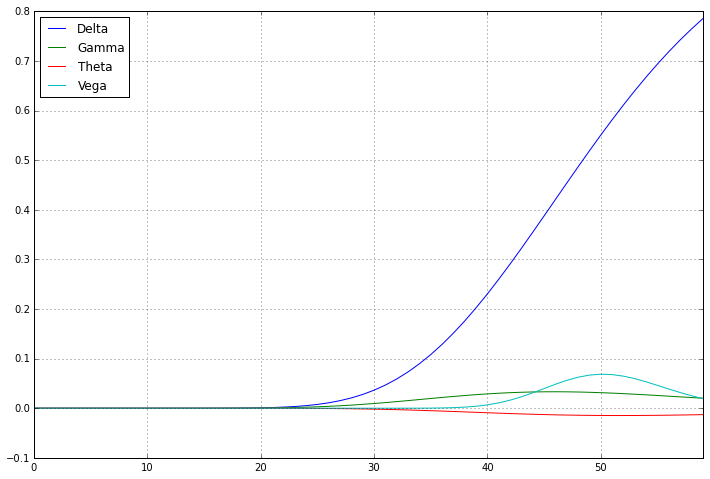

In [51]:
greeks[['Delta', 'Gamma', 'Theta', 'Vega']].plot(figsize=(12,8));
#plt.savefig('5104OS_08_54.png', bbox_inches='tight', dpi=300)